# Project

# Useful things

# Olfaction

**Summary:** In this tutorial, we will implement a something that can change the world.

The detailed documentation of the `OdorArena` class can be found in the [API reference](https://neuromechfly.org/api_ref/arena.html#flygym.mujoco.arena.OdorArena). Its implementation is beyond the scope of this tutorial but can be found [here](https://github.com/NeLy-EPFL/flygym/blob/main/flygym/mujoco/arena/sensory_environment.py).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from gymnasium.utils.env_checker import check_env

from flygym import Fly, Camera
from flygym.arena import FlatTerrain
from flygym.examples.obstacle_arena import ObstacleOdorArena
from flygym.examples.turning_controller import HybridTurningNMF

In [2]:
from pathlib import Path

Path("./outputs").mkdir(exist_ok=True)

In [3]:
odor_source = np.array([[0, 0, 0.2]])
peak_odor_intensity = np.array([[1, 0]])
marker_colors = [[255, 127, 14]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])
odor_dimensions = len(peak_odor_intensity[0])

In [4]:
# We start by creating a simple arena
flat_terrain_arena = FlatTerrain()

# Then, we add visual and olfactory features on top of it
arena = ObstacleOdorArena(
    terrain=flat_terrain_arena,
    obstacle_positions=np.array([(-100, 0), (125, 5), (175, -5)]),
    odor_source=odor_source,
    peak_odor_intensity=peak_odor_intensity,
    marker_size=0.5,
    obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.2, 0.8, 0.2, 1), (0.2, 0.2, 0.8, 1)],
    user_camera_settings=((13, -18, 20), (np.deg2rad(65), 0, 0), 45),
)

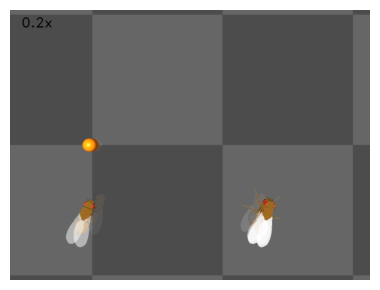

In [11]:
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

fly = Fly(
    spawn_pos=(13, -5, 0.2),
    #spawn_pos=(0, -5, 0.2),
    spawn_orientation=(0, 0, np.pi / 2 + np.deg2rad(70)),
    contact_sensor_placements=contact_sensor_placements,
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
)

cam = Camera(fly=fly, play_speed=0.2, camera_id="birdeye_cam")
#cam = Camera(fly=fly, play_speed=0.2, camera_id="user_cam")
sim = HybridTurningNMF(fly=fly, cameras=[cam], arena=arena)

for i in range(500):
    obs, reward, terminated, truncated, info = sim.step(np.zeros(2))
    sim.render()

fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.imshow(cam._frames[-1])
ax.axis("off")
fig.savefig("./outputs/vision_sim_env.png")

====================================================================================================

## Odor arena

To demonstrate odor sensing, let's create an environment with one attractive odor source and two aversive odor sources. The dimension of this odor space is 2 (attractive, aversive) despite the number of odor sources being 3. The odor sources share a peak intensity of 1. We will color the attractive odor source orange and the aversive odor sources blue.

In [6]:
import numpy as np

# random state seed for reproducibility
seed = 1

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5], [16, 4, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimensions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_odor_intensity = np.array([[1, 0], [0, 1], [0, 1]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
marker_colors = [[255, 127, 14], [31, 119, 180], [31, 119, 180]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimensions = len(peak_odor_intensity[0])

Let's create the arena using these parameters. The detailed documentation of the `OdorArena` class can be found in the [API reference](https://neuromechfly.org/api_ref/arena.html#flygym.mujoco.arena.OdorArena). Its implementation is beyond the scope of this tutorial but can be found [here](https://github.com/NeLy-EPFL/flygym/blob/main/flygym/mujoco/arena/sensory_environment.py).

In [7]:
from flygym.arena import OdorArena

arena = OdorArena(
    odor_source=odor_source,
    peak_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,
    marker_colors=marker_colors,
    marker_size=0.3,
)

TypeError: OdorArena.__init__() got an unexpected keyword argument 'peak_intensity'

Let’s place our fly in the arena. As before, we will run a few iterations to allow it to stand on the ground in a stable manner.

Note that we will be using the `HybridTurningNMF` as the turning controller. This class serves as an enhanced version of the `TurningNMF` in the previous exercises, utilizing sensory feedback to prevent the fly from stumbling. For further details, refer to https://neuromechfly.org/tutorials/hybrid_controller.html and https://neuromechfly.org/tutorials/turning.html.

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from flygym import Parameters
from flygym.examples.turning_controller import HybridTurningNMF


Path("./outputs").mkdir(exist_ok=True)


contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
)
for i in range(500):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")
fig.savefig("./outputs/olfaction_env.png")

NameError: name 'arena' is not defined

We can visualize the fly trajectory:

In [ ]:
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 25)
ax.set_ylim(-5, 5)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig("./outputs/odor_taxis_trajectory.png")

NameError: name 'obs_hist' is not defined

We can also generate the video:

In [ ]:
sim.save_video("./outputs/odor_taxis.mp4")

from IPython import display

display.Video("./outputs/odor_taxis.mp4")

NameError: name 'sim' is not defined